In [1]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [2]:
import pandas as pd
from fbprophet import Prophet

In [3]:
# reflect an existing database into a new model
Base = automap_base()

In [4]:
engine = create_engine("sqlite:///../sqlite_db/stock_market_sqlite.db")

In [5]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
bases = Base.classes.keys()
bases

['GME', 'MSFT', 'TSLA']

In [7]:
# Save references to each table
tesla = Base.classes.TSLA
microsoft = Base.classes.MSFT
gamestop = Base.classes.GME

In [8]:
# Create session (link) from Python to the DB
session = Session(engine)

In [9]:
# Perform a query to retrieve tesla data
tesla_results = session.query(tesla.Date, tesla.Close).all()
tesla_df = pd.DataFrame(tesla_results, columns=["Date", "Close"])

In [10]:
tesla_df

,Date,Close
0,2015-12-31,48.001999
1,2016-01-04,44.681999
2,2016-01-05,44.686001
3,2016-01-06,43.807999
4,2016-01-07,43.130001
...,...,...
1284,2021-02-08,863.419983
1285,2021-02-09,849.460022
1286,2021-02-10,804.820007
1287,2021-02-11,811.659973


In [11]:
# Rename features as these names are needed for model fitting
tesla_df = tesla_df.rename(columns={"Date":"ds", "Close":"y"})

In [12]:
tesla_df

,ds,y
0,2015-12-31,48.001999
1,2016-01-04,44.681999
2,2016-01-05,44.686001
3,2016-01-06,43.807999
4,2016-01-07,43.130001
...,...,...
1284,2021-02-08,863.419983
1285,2021-02-09,849.460022
1286,2021-02-10,804.820007
1287,2021-02-11,811.659973


In [13]:
m = Prophet(daily_seasonality = True) # the Prophet class (model)
m.fit(tesla_df) # fit the model using all data

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [27]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, horizon = '365 days')

INFO:fbprophet:Making 3 forecasts with cutoffs between 2019-02-13 00:00:00 and 2020-02-13 00:00:00
100%|██████████| 3/3 [00:17<00:00,  5.75s/it]


In [28]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-02-14,65.809219,60.455786,70.657743,60.754002,2019-02-13
1,2019-02-15,65.900198,60.682344,70.928743,61.576000,2019-02-13
2,2019-02-19,67.094258,61.722921,71.841812,61.127998,2019-02-13
3,2019-02-20,67.278325,62.189617,72.477941,60.512001,2019-02-13
4,2019-02-21,67.432598,62.530521,72.697152,58.245998,2019-02-13
...,...,...,...,...,...,...
751,2021-02-08,197.465913,119.767604,272.026653,863.419983,2020-02-13
752,2021-02-09,197.672099,121.637825,270.178612,849.460022,2020-02-13
753,2021-02-10,197.676676,118.724785,270.575872,804.820007,2020-02-13
754,2021-02-11,197.791700,120.440615,272.118959,811.659973,2020-02-13


In [29]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days 00:00:00,577.697362,24.035336,17.559463,0.202039,0.203139,0.213333
1,36 days 12:00:00,579.945899,24.082066,17.728709,0.205546,0.207133,0.200000
2,37 days 00:00:00,569.257886,23.859126,17.600001,0.207027,0.211708,0.193333
3,39 days 00:00:00,570.351731,23.882038,17.710990,0.209732,0.211708,0.186667
4,39 days 12:00:00,572.623810,23.929559,17.872045,0.213043,0.219357,0.173333
...,...,...,...,...,...,...,...
500,363 days 00:00:00,170965.208594,413.479393,328.733389,0.696346,0.776142,0.000000
501,363 days 12:00:00,169964.195873,412.267141,328.805006,0.703014,0.776374,0.000000
502,364 days 00:00:00,171924.808628,414.638166,330.551434,0.700671,0.776142,0.000000
503,364 days 12:00:00,170555.126969,412.983204,330.379571,0.707017,0.776374,0.000000


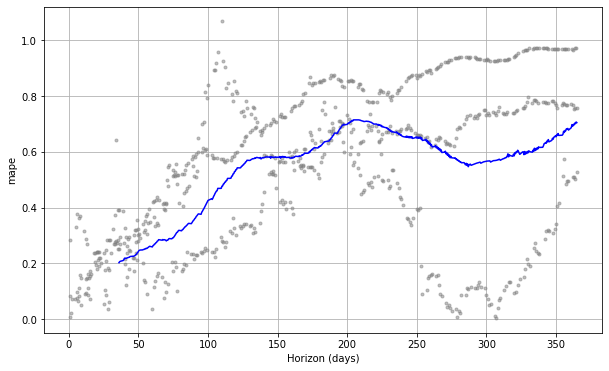

In [30]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [31]:
stonks = [tesla, microsoft, gamestop]

In [37]:
import matplotlib.pyplot as plt

In [38]:
def plot_cross_validation(stonk):
    results = session.query(stonk.Date, stonk.Close).all()
    df = pd.DataFrame(results, columns=["Date", "Close"])
    data = df.rename(columns={"Date":"ds", "Close":"y"})
    m = Prophet(daily_seasonality = True)
    m.fit(data)
    df_cv = cross_validation(m, horizon = '365 days')
    df_p = performance_metrics(df_cv)
    print(df_p)
    fig = plot_cross_validation_metric(df_cv, metric='mape')

    return
    fig

INFO:fbprophet:Making 3 forecasts with cutoffs between 2019-02-13 00:00:00 and 2020-02-13 00:00:00
100%|██████████| 3/3 [00:17<00:00,  5.74s/it]
              horizon            mse        rmse         mae      mape  \
0    36 days 00:00:00     577.697362   24.035336   17.559463  0.202039   
1    36 days 12:00:00     579.945899   24.082066   17.728709  0.205546   
2    37 days 00:00:00     569.257886   23.859126   17.600001  0.207027   
3    39 days 00:00:00     570.351731   23.882038   17.710990  0.209732   
4    39 days 12:00:00     572.623810   23.929559   17.872045  0.213043   
..                ...            ...         ...         ...       ...   
500 363 days 00:00:00  170965.208594  413.479393  328.733389  0.696346   
501 363 days 12:00:00  169964.195873  412.267141  328.805006  0.703014   
502 364 days 00:00:00  171924.808628  414.638166  330.551434  0.700671   
503 364 days 12:00:00  170555.126969  412.983204  330.379571  0.707017   
504 365 days 00:00:00  172088.839332  414

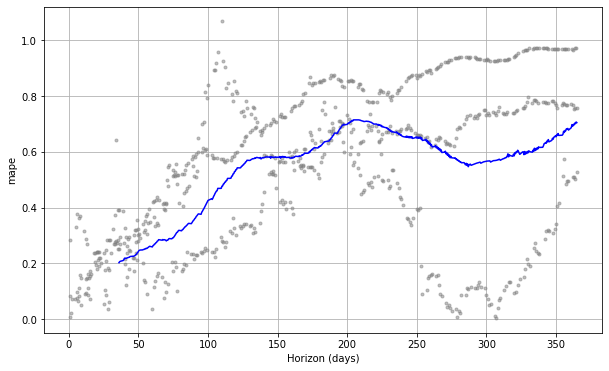

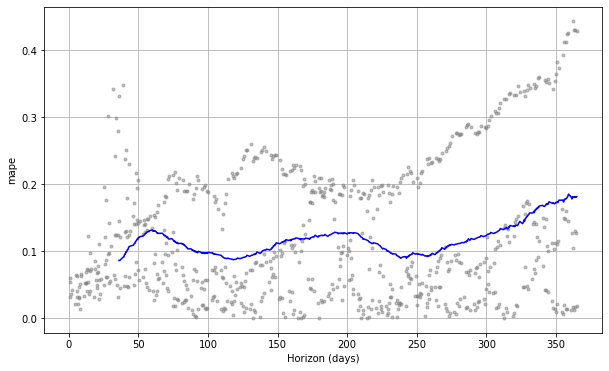

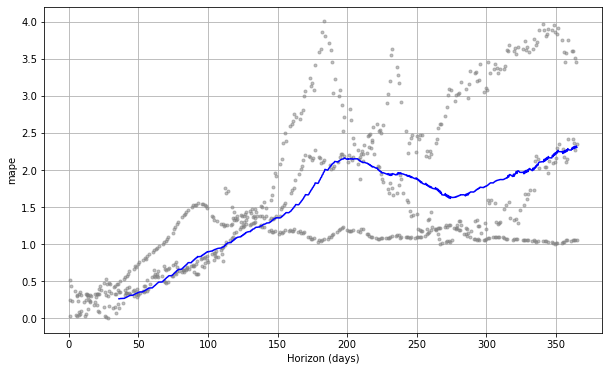

In [39]:
for stonk in stonks:
    plot_cross_validation(stonk)